# Propensity to fund mortgages

Author: Yoann Pradat

Competition hosted on crowdanalytix.com. It aims at predicting whether a mortgage will be funded or not based on applicant's data. It is therefore a binary classification problem.

In [1]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
import pandas as pd

import os
import sys

import itertools
import time
import warnings

from sklearn.preprocessing import LabelEncoder

# I- Load and visualize the data

In [2]:
# Load data
data_train = pd.read_csv("../data/CAX_MortgageModeling_Train.csv") 
data_test = pd.read_csv("../data/CAX_MortgageModeling_Test.csv", usecols=lambda x: x not in ["RESULT"]) 

# Lower case column names
data_train.columns = list(map(str.lower, data_train.columns))
data_test.columns = list(map(str.lower, data_test.columns))

n_train, ncol_train = data_train.shape
n_test, ncol_test = data_test.shape
print("="*40)
print("train")
print("%d rows,  %d cols" % (n_train, ncol_train))
print("%d cells missing data" % data_train.isna().sum().sum())
print("="*40)
print("test")
print("%d rows,  %d cols" % (n_test, ncol_test))
print("%d cells missing data" % data_test.isna().sum().sum())
print("="*40)
print("number of unique elements & type")
dict_var = {"train": data_train.iloc[:, :-1].nunique(), 
            "test": data_test.nunique(),
            "dtype": data_test.dtypes}
df_var = pd.DataFrame(dict_var)
print(df_var)
print("="*40)

train
45642 rows,  22 cols
0 cells missing data
test
15214 rows,  21 cols
0 cells missing data
number of unique elements & type
                   train   test    dtype
unique_id          45642  15214   object
mortgage number    45642  15214    int64
property value      1705   1286    int64
mortgage payment    6430   4603    int64
gds                 6027   4769  float64
ltv                 5811   3074  float64
tds                 5704   3919  float64
amortization           8      7    int64
mortgage amount    10185   4823  float64
rate                  27     23  float64
mortgage purpose       2      2   object
payment frequency      6      6   object
property type          8      8   object
term                   6      6    int64
fsa                 1141   1000   object
age range             11     11   object
gender                 3      3   object
income               730    555    int64
income type           21     20    int64
naics code            19     19   object
credit scor

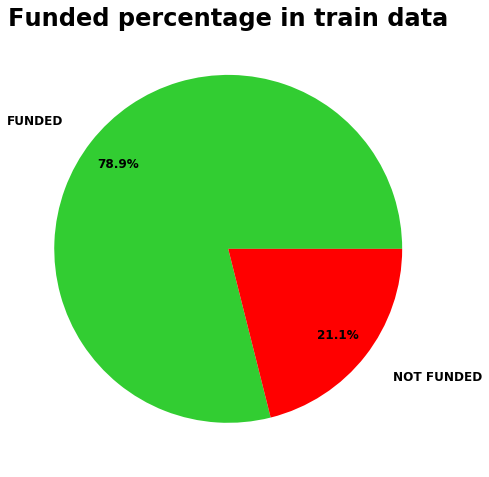

In [596]:
# Simple pie of funding frequency
colors = ['limegreen', 'red']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.pie(x=data_train.result.value_counts().values, labels=data_train.result.value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors, autopct='%1.1f%%')
ax.set_title("Funded percentage in train data", fontweight='bold', fontsize=24)
plt.show()

Let's make all categorical features of type object, all other features being integer of float. 

In [551]:
cols_cat = ['amortization', 'rate', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range',
           'gender', 'income type', 'naics code']

data_train[cols_cat] = data_train[cols_cat].astype('object')
data_test[cols_cat] = data_test[cols_cat].astype('object')

dict_var = {"train": data_train.iloc[:, :-1].nunique(), 
            "test": data_test.nunique(),
            "dtype": data_test.dtypes}
df_var = pd.DataFrame(dict_var)

print("="*40)
print(df_var)
print("="*40)

                   train   test    dtype
unique_id          45642  15214   object
mortgage number    45642  15214    int64
property value      1705   1286    int64
mortgage payment    6430   4603    int64
gds                 6027   4769  float64
ltv                 5811   3074  float64
tds                 5704   3919  float64
amortization           8      7   object
mortgage amount    10185   4823  float64
rate                  27     23   object
mortgage purpose       2      2   object
payment frequency      6      6   object
property type          8      8   object
term                   6      6   object
fsa                 1141   1000   object
age range             11     11   object
gender                 3      3   object
income               730    555    int64
income type           21     20   object
naics code            19     19   object
credit score         469    443    int64


Let's visualize how labels are spread according to object (categorial) variables.  

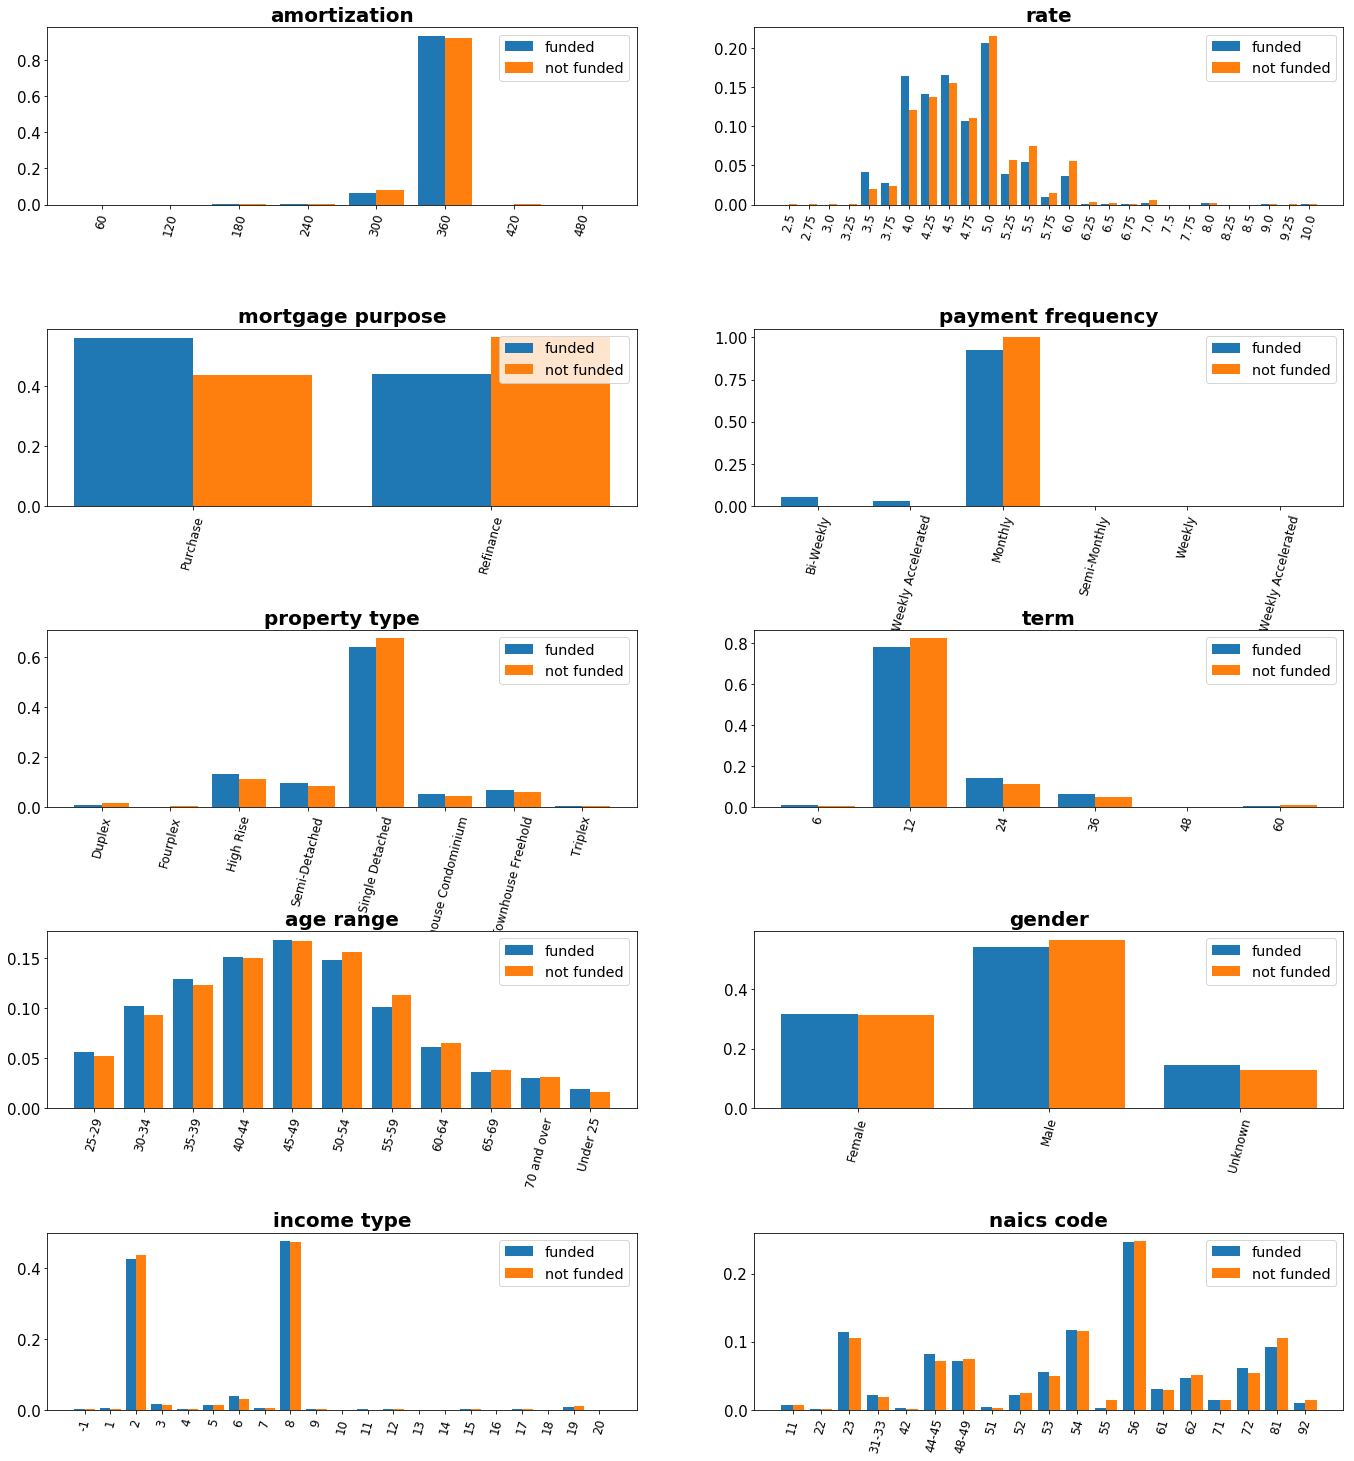

In [552]:
# Choose which variable to treat as categorical
cols_cat = df_var[df_var.dtype==object].index.values
cols_cat_plot = [x for x in cols_cat if x not in ['unique_id', 'fsa']]

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 24))
ax = ax.flatten()
for i, x in enumerate(cols_cat_plot):
    x_funded = data_train.loc[data_train.result=="FUNDED", x].values
    x_not_funded = data_train.loc[data_train.result=="NOT FUNDED", x].values

    bins = np.arange(data_train[x].nunique())
    bins_l = bins - 0.499
    bins_u = bins + 0.499
    bins = list(np.sort(np.hstack((bins_l, bins_u))))

    lc = LabelEncoder()
    lc.fit(np.hstack((x_funded, x_not_funded)))
    ax[i].hist([lc.transform(x_funded), lc.transform(x_not_funded)], density=1, bins=bins,
                label=['funded', 'not funded'], alpha=1.0)
    ax[i].set_xticks(np.arange(lc.classes_.shape[0]))
    ax[i].set_xticklabels([c if type(c)==str else c for c in lc.classes_])
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(75)
    ax[i].tick_params(axis='y', which='major', labelsize=15)
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].set_xlabel('')
    ax[i].set_title("%s"%x, fontweight='bold', fontsize=20)
    ax[i].legend(loc='best', fontsize='x-large')
fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90,wspace=0.2, hspace=0.7)
plt.show(fig)

No modality of any of the categorial variables shows a significative difference between funded or not funded except maybe for the mortgage purpose: a mortgage for purchase is more often funded than for refinance. We also observe that the higher the rate the higher the chance of getting funded.

We are definitely going to have to dive into a more refined analysis but let's first check distribution according to numerical variables and also how features correlate between themselves.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


variable gds and funded mask has 53 neg values
variable gds and not funded mask has 56 neg values
variable tds and funded mask has 2 neg values
variable tds and not funded mask has 4 neg values


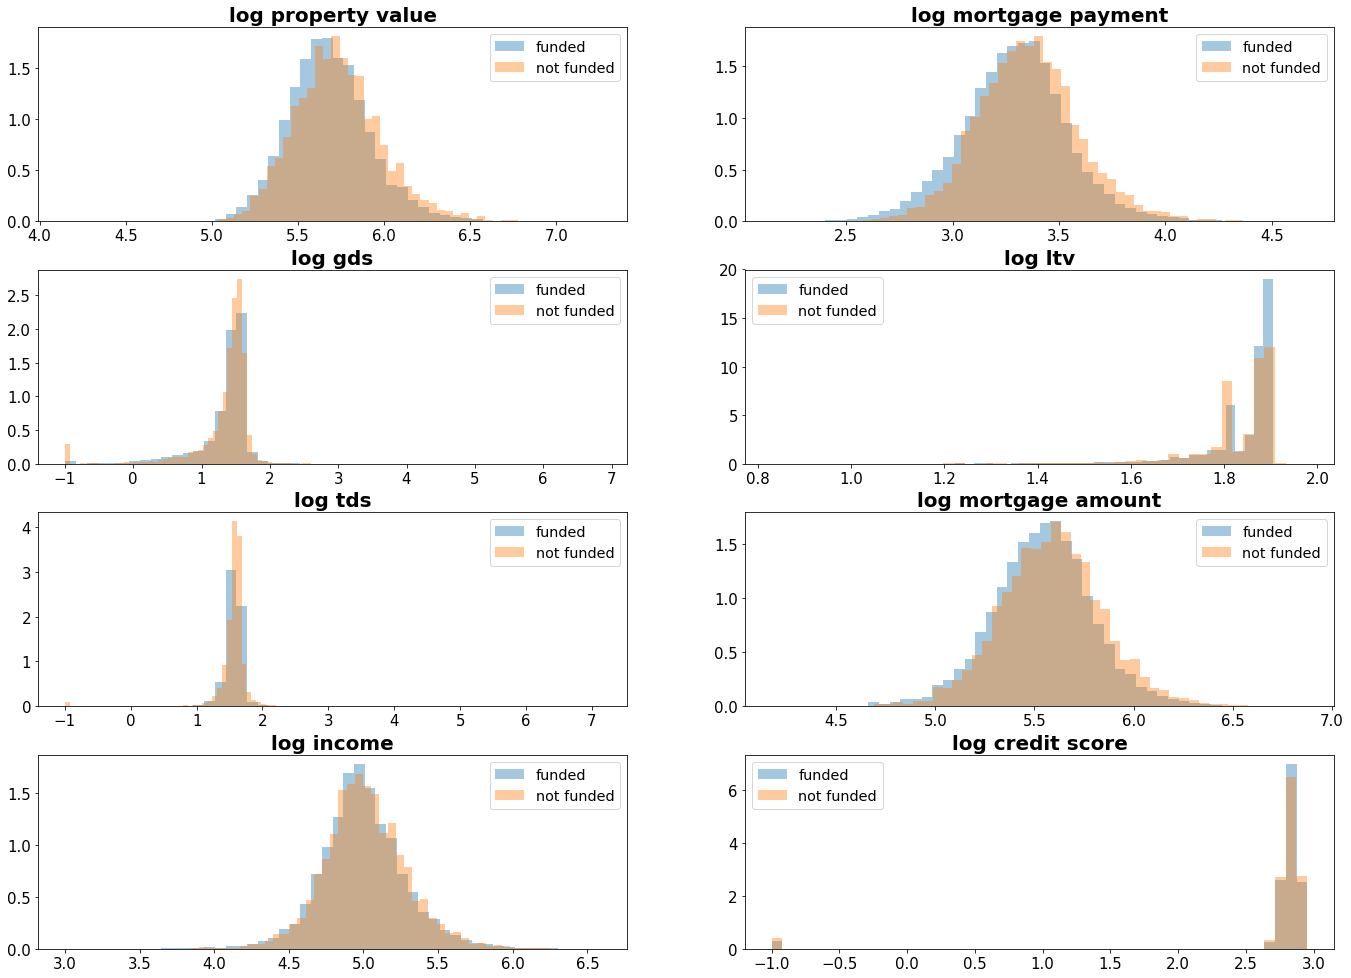

In [553]:
cols_num = [x for x in data_train.columns if x not in cols_cat and x not in ['result', 'mortgage number']]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 16))
ax = ax.flatten()
for i, x in enumerate(cols_num):
    eps = 1e-1
    x_funded = data_train.loc[data_train.result=="FUNDED", x].values
    x_not_funded = data_train.loc[data_train.result=="NOT FUNDED", x].values
    
    # In case some values are below 0 set them to
    n_neg_funded = sum(x_funded < 0)
    n_neg_not_funded = sum(x_not_funded < 0)
    if n_neg_funded:
        print("variable %s and funded mask has %d neg values" % (x, n_neg_funded))
        x_funded[x_funded < 0] = 0
    if n_neg_not_funded:
        print("variable %s and not funded mask has %d neg values" % (x, n_neg_not_funded))
        x_not_funded[x_not_funded < 0] = 0
    
    # Log transform
    x_funded = np.log10(x_funded + eps)
    x_not_funded = np.log10(x_not_funded + eps)
    
    sns.distplot(x_funded, norm_hist=True, kde=False, ax=ax[i], label='funded')
    sns.distplot(x_not_funded, norm_hist=True, kde=False, ax=ax[i], label='not funded',)

    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].set_xlabel('')
    ax[i].ticklabel_format(axis='both', style='sci')
    ax[i].set_title("log %s"%x, fontweight='bold', fontsize=20)
    ax[i].legend(loc='best', fontsize='x-large')
fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90, hspace=0.25)
plt.show(fig)

### Extreme values of numeric features

### GDS or measure of percentage of Gross Annual Income required for Housing Expenses

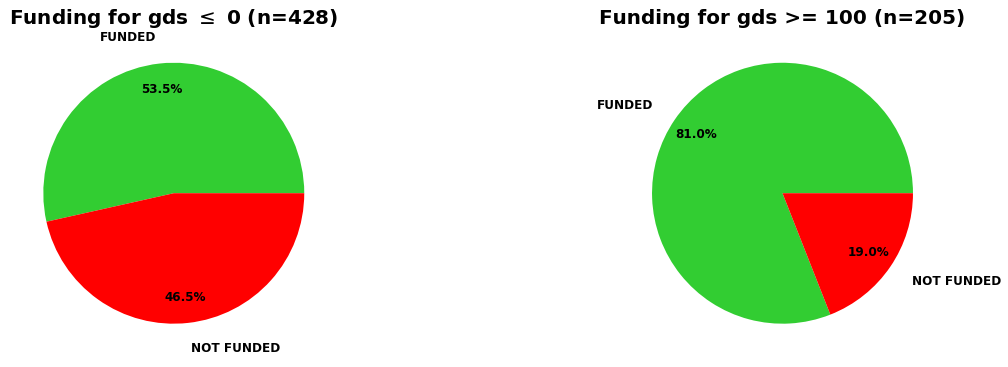

In [673]:
# Simple pies of classes frequency
var = 'gds'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
colors_dict = {'FUNDED': 'limegreen', 'NOT FUNDED': 'red'}

lim = 0
mask = data_train[var] <= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[0].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[0].set_title(r"Funding for %s $\leq$ %.2g (n=%d)" % (var, lim, sum(mask)) , fontweight='bold', fontsize=20)
ax[0].set_aspect('equal')
ax[0].yaxis.set_label_coords(-0.01, 0.5)

lim = 100
mask = data_train[var] >= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[1].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[1].set_title("Funding for %s >= %.3g (n=%d)" % (var, lim, sum(mask)), fontweight='bold', fontsize=20)
ax[1].set_aspect('equal')
ax[1].yaxis.set_label_coords(-0.01, 0.5)

plt.show()

### TDS or measure of percentage of Gross Annual Income required for Housing Expenses and other

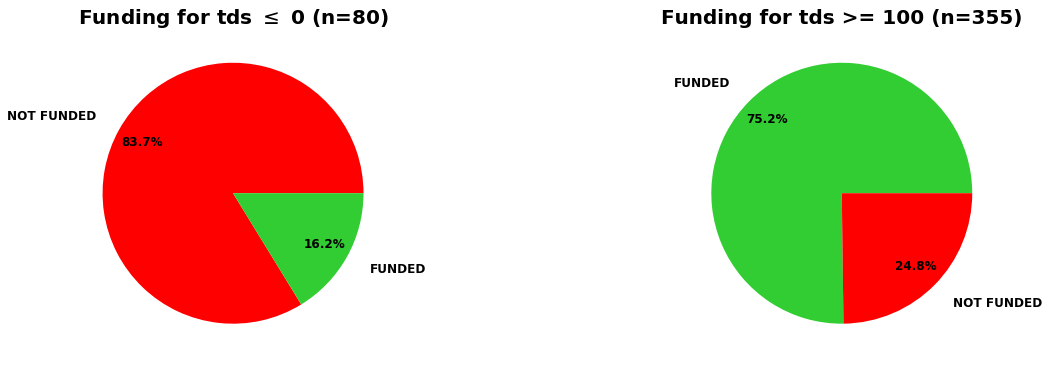

In [663]:
# Simple pies of classes frequency
var = 'tds'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
colors_dict = {'FUNDED': 'limegreen', 'NOT FUNDED': 'red'}

lim = 0
mask = data_train[var] <= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[0].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[0].set_title(r"Funding for %s $\leq$ %.2g (n=%d)" % (var, lim, sum(mask)) , fontweight='bold', fontsize=20)
ax[0].set_aspect('equal')
ax[0].yaxis.set_label_coords(-0.01, 0.5)

lim = 100
mask = data_train[var] >= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[1].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[1].set_title("Funding for %s >= %.3g (n=%d)" % (var, lim, sum(mask)), fontweight='bold', fontsize=20)
ax[1].set_aspect('equal')
ax[1].yaxis.set_label_coords(-0.01, 0.5)

plt.show()

## Credit score

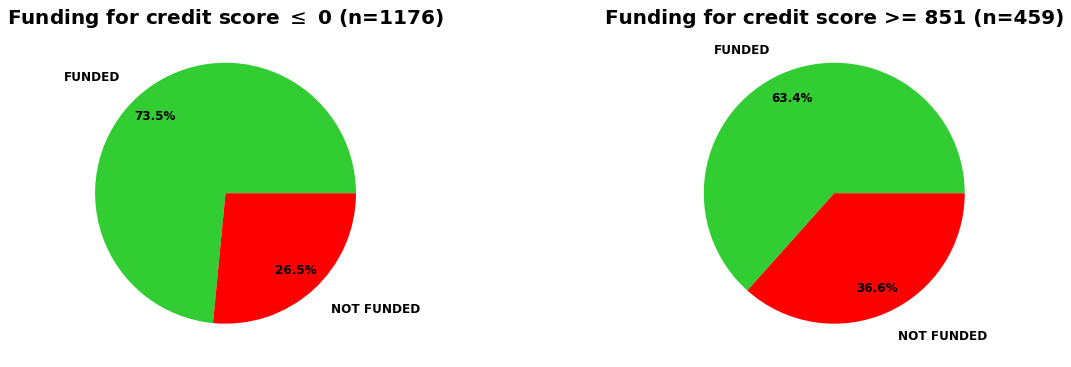

In [664]:
# Simple pies of classes frequency
var = 'credit score'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
colors_dict = {'FUNDED': 'limegreen', 'NOT FUNDED': 'red'}

lim = 0
mask = data_train[var] <= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[0].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[0].set_title(r"Funding for %s $\leq$ %.2g (n=%d)" % (var, lim, sum(mask)) , fontweight='bold', fontsize=20)
ax[0].set_aspect('equal')
ax[0].yaxis.set_label_coords(-0.01, 0.5)

lim = data_train[var].quantile(0.99)
mask = data_train[var] >= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[1].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[1].set_title("Funding for %s >= %.3g (n=%d)" % (var, lim, sum(mask)), fontweight='bold', fontsize=20)
ax[1].set_aspect('equal')
ax[1].yaxis.set_label_coords(-0.01, 0.5)

plt.show()

## Loan to value

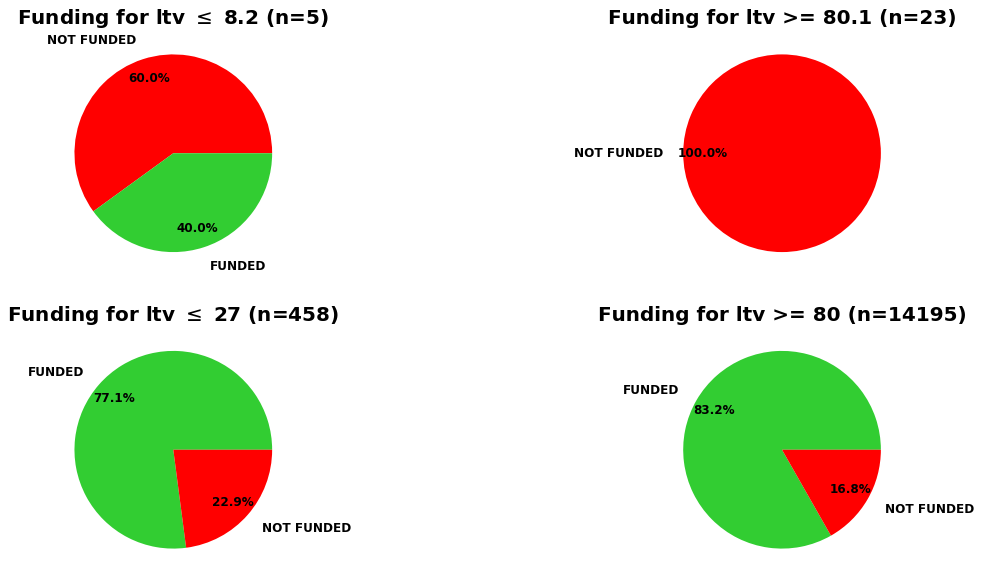

In [666]:
# Simple pies of classes frequency
var = 'ltv'
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ax = ax.flatten()
colors_dict = {'FUNDED': 'limegreen', 'NOT FUNDED': 'red'}

lim = data_train[var].quantile(0.0001)
mask = data_train[var] <= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[0].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[0].set_title(r"Funding for %s $\leq$ %.2g (n=%d)" % (var, lim, sum(mask)) , fontweight='bold', fontsize=20)
ax[0].set_aspect('equal')
ax[0].yaxis.set_label_coords(-0.01, 0.5)

lim = data_train[var].quantile(0.01)
mask = data_train[var] <= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[2].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[2].set_title(r"Funding for %s $\leq$ %.2g (n=%d)" % (var, lim, sum(mask)) , fontweight='bold', fontsize=20)
ax[2].set_aspect('equal')
ax[2].yaxis.set_label_coords(-0.01, 0.5)

lim = 80.1
mask = data_train[var] >= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[1].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[1].set_title("Funding for %s >= %.3g (n=%d)" % (var, lim, sum(mask)), fontweight='bold', fontsize=20)
ax[1].set_aspect('equal')
ax[1].yaxis.set_label_coords(-0.01, 0.5)

lim = data_train[var].quantile(0.99)
mask = data_train[var] >= lim
colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
ax[3].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
       pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
       colors=colors_ordered, autopct='%1.1f%%')
ax[3].set_title("Funding for %s >= %.3g (n=%d)" % (var, lim, sum(mask)), fontweight='bold', fontsize=20)
ax[3].set_aspect('equal')
ax[3].yaxis.set_label_coords(-0.01, 0.5)

plt.show()

For some reason there is a huge peak at 80 for the variable ltv. Might want to take that into account later on. It probably is because **the loan is never funded fro ltv > 80**. 

## Other numeric variables

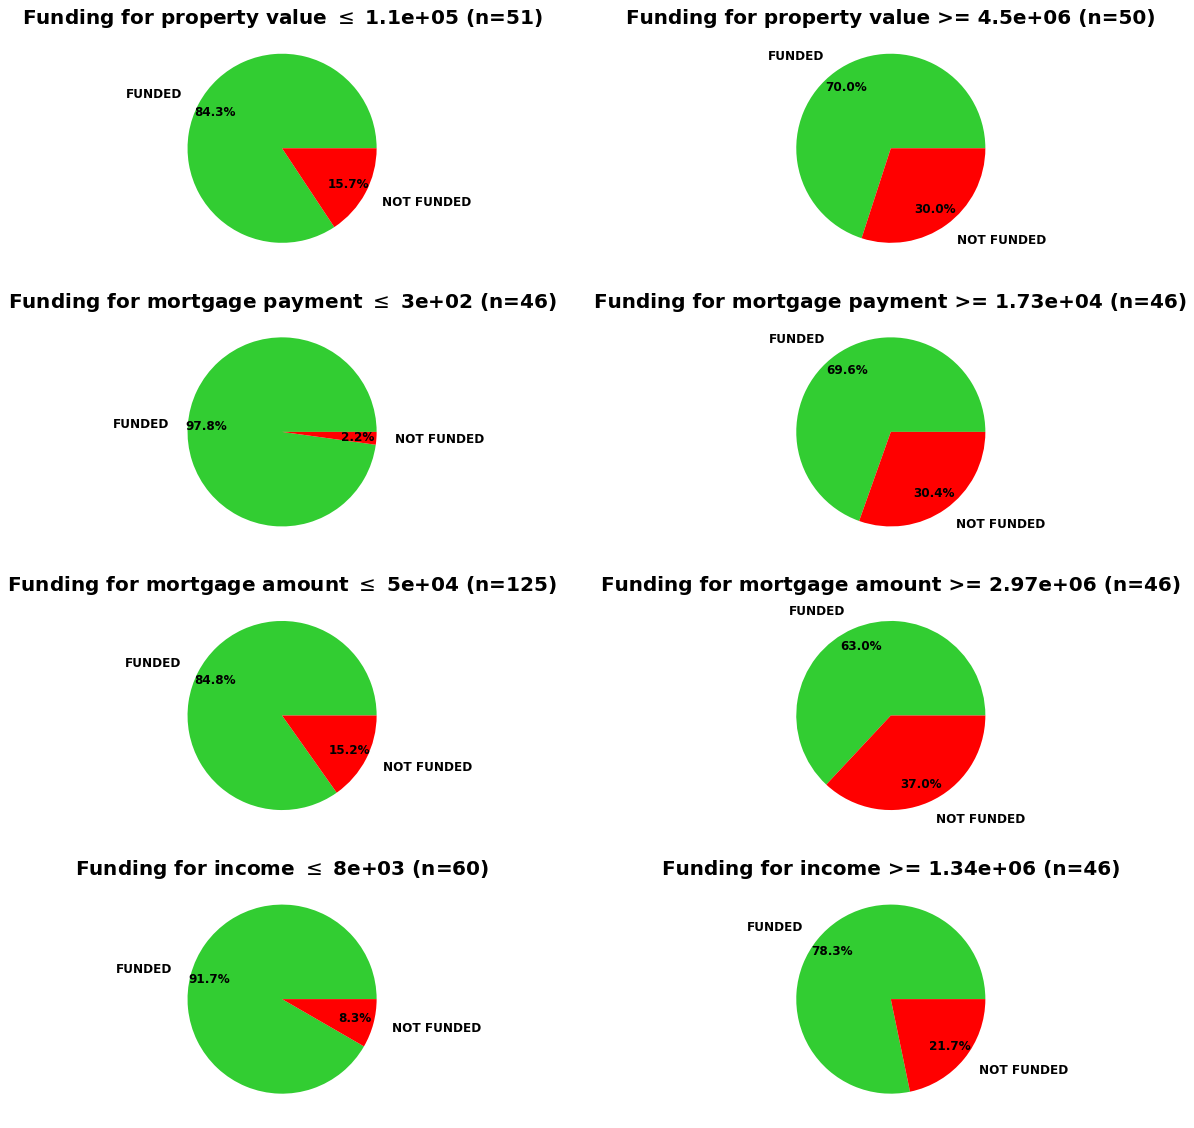

In [667]:
# Simple pies of classes frequency
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
ax = ax.flatten()
offset = 0
for var in ['property value', 'mortgage payment', 'mortgage amount', 'income']:
    colors_dict = {'FUNDED': 'limegreen', 'NOT FUNDED': 'red'}

    lim = data_train[var].quantile(0.001)
    mask = data_train[var] <= lim
    colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
    ax[0+offset].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
           pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
           colors=colors_ordered, autopct='%1.1f%%')
    ax[0+offset].set_title(r"Funding for %s $\leq$ %.2g (n=%d)" % (var, lim, sum(mask)) , fontweight='bold', fontsize=20)
    ax[0+offset].set_aspect('equal')
    ax[0+offset].yaxis.set_label_coords(-0.01, 0.5)

    lim = data_train[var].quantile(0.999)
    mask = data_train[var] >= lim
    colors_ordered = [colors_dict[x] for x in data_train[mask].result.value_counts().index]
    ax[1+offset].pie(x=data_train[mask].result.value_counts().values, labels=data_train.result[mask].value_counts().index,
           pctdistance=0.8, labeldistance=1.2, textprops={'fontsize':12, 'fontweight':'bold'},
           colors=colors_ordered, autopct='%1.1f%%')
    ax[1+offset].set_title("Funding for %s >= %.3g (n=%d)" % (var, lim, sum(mask)), fontweight='bold', fontsize=20)
    ax[1+offset].set_aspect('equal')
    ax[1+offset].yaxis.set_label_coords(-0.01, 0.5)

    offset += 2
plt.show()

Observe that for very low mortgage payment the loan is nearly always funded. 

### Correlation heatmap

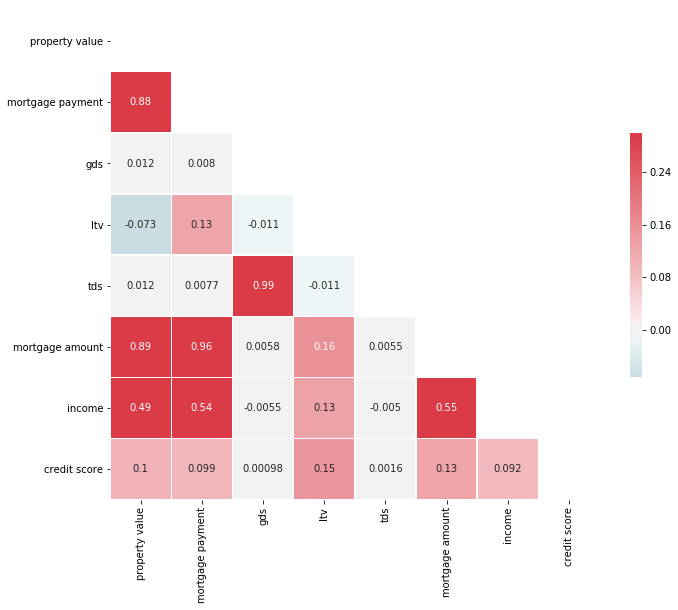

In [670]:
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr = data_train.iloc[:, 2:].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=.3, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show(fig)

### Feature engineering

In [693]:
data_train.loc[:, 'tmgds'] = data_train.loc[:, 'tds'] - data_train.loc[:, 'gds']

variable tmgds and funded mask has 12 neg values
variable tmgds and not funded mask has 5 neg values


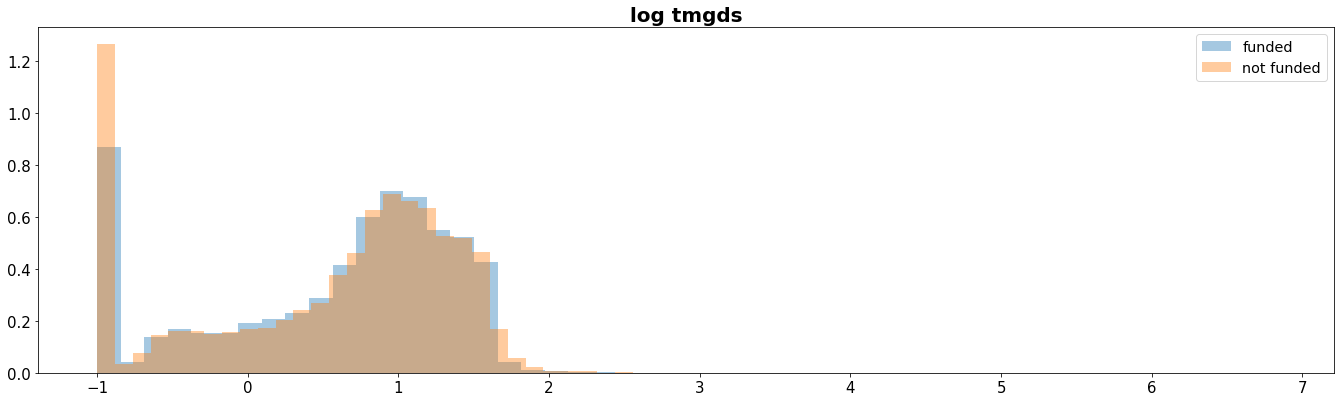

In [694]:
x = 'tmgds'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
eps = 1e-1
x_funded = data_train.loc[data_train.result=="FUNDED", x].values
x_not_funded = data_train.loc[data_train.result=="NOT FUNDED", x].values

# In case some values are below 0 set them to
n_neg_funded = sum(x_funded < 0)
n_neg_not_funded = sum(x_not_funded < 0)
if n_neg_funded:
    print("variable %s and funded mask has %d neg values" % (x, n_neg_funded))
    x_funded[x_funded < 0] = 0
if n_neg_not_funded:
    print("variable %s and not funded mask has %d neg values" % (x, n_neg_not_funded))
    x_not_funded[x_not_funded < 0] = 0

# Log transform
x_funded = np.log10(x_funded + eps)
x_not_funded = np.log10(x_not_funded + eps)

sns.distplot(x_funded, norm_hist=True, kde=False, ax=ax, label='funded')
sns.distplot(x_not_funded, norm_hist=True, kde=False, ax=ax, label='not funded',)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('')
ax.ticklabel_format(axis='both', style='sci')
ax.set_title("log %s"%x, fontweight='bold', fontsize=20)
ax.legend(loc='best', fontsize='x-large')
fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90, hspace=0.25)
plt.show(fig)

# II. Toy models

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC

In [3]:
class Ignore(BaseEstimator, TransformerMixin):
    def __init__(self, cols_ignore):
        self.cols_ignore=cols_ignore
    def fit(self, X, y):
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in self.cols_ignore:
            del Xc[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Preprocesser(BaseEstimator, TransformerMixin):
    def __init__(self, cols_num, eps=1e-1):
        self.cols_num=cols_num
        self.esp = eps
    def fit(self, X, y):
        self.tds_upper = X.tds.quantile(0.99)
        self.gds_upper = X.gds.quantile(0.99)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        # Indicator of extreme values
        Xc.loc[:, 'tds_le_0'] = np.where(Xc.tds <= 0, 1, 0)
        Xc.loc[:, 'ltv_gt_80'] = np.where(Xc.ltv > 80, 1, 0)
        # Clip too extreme values of tds and tmgds
        Xc.loc[:, 'tds'] = Xc.tds.clip(lower=0, upper=self.tds_upper)
        Xc.loc[:, 'gds'] = Xc.gds.clip(lower=0, upper=self.gds_upper)
        # Log transform
        eps = 1e-1
        for x in self.cols_num:
            Xc.loc[:, x] = np.log10(Xc[x] + eps)
        # As gds and tds are very correlated (0.99) we will only keep tds and add feature tds - gds
        Xc.loc[:, 'tmgds'] = Xc.loc[:, 'tds'] - Xc.loc[:, 'gds']
        del Xc['gds']
        return Xc  

class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, center=True, norm_ord=2):
        self.center=center
        self.norm_ord=norm_ord
    def fit(self, X, y):
        n, _ = X.shape
        self.centers = {}
        self.norms = {}
        for x in X:
            if X[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                center = np.mean(X[x])
                norm = np.linalg.norm(X[x]-center)
                self.centers[x] = center
                self.norms[x] = norm/np.sqrt(n)
            else:
                norm = np.linalg.norm(X[x]-center, ord=norm_ord)
                self.norms[x] = norm/np.sqrt(n)
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        for x in Xc:
            if Xc[x].dtype=='object' or set(X[x].unique()).issubset(set([0,1])):
                pass
            elif self.center:
                Xc.loc[:, x] = (Xc[x]-self.centers[x])/self.norms[x]
            else:
                Xc.loc[:, x] = Xc[x]/self.norms[x]
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols_onehot, categories, other_thresh=0.02):
        self.cols_onehot = cols_onehot
        self.categories = categories
        self.other_thres = other_thresh
    def fit(self, X, y):
#         n, _ = X.shape
#         self.category_other = {}
#         for x, category in zip(self.cols_onehot, self.categories):
#             category_other = []
#             x_counts = X[x].value_counts()
#             for cat in category:
#                 if cat not in x_counts.index:
#                     category_other.append(cat)
#                 elif x_counts[cat]/n < self.other_thresh:
#                     category_other.append(cat)
#             self.category_other[x] = category_other
#         Xc = pd.DataFrame.copy(X)
#         for x, category_other in zip(self.cols_onehot, self.category_other):
#             Xc.loc[Xc[x].isin(category_other), :] = 'other'
        self.onehotenc = OneHotEncoder(categories=self.categories)
        self.onehotenc.fit(X[self.cols_onehot])
        return self
    def transform(self, X):
        Xc = pd.DataFrame.copy(X)
        Xdummy = self.onehotenc.transform(X[self.cols_onehot])
        Xdummy = Xdummy.toarray()
        cols_Xdummy = ['']*Xdummy.shape[1]
        offset = 0
        for x, category in zip(self.cols_onehot, self.categories):
            for i, cat in enumerate(category):
                cols_Xdummy[offset + i] = '%s_%s' % (x, str(cat))
            offset += len(category)
            del Xc[x]
        Xdummy = pd.DataFrame(Xdummy, columns=cols_Xdummy).astype(int)
        Xdummy.index = index=Xc.index
        for x, category in zip(self.cols_onehot, self.categories):
            del Xdummy['%s_%s' % (x, str(category[0]))]
        Xc = pd.concat((Xc, Xdummy), axis=1)
        return Xc
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)
    
def plot_learning_curve(best_params, cv_results, params_logscale=None):
    ncols = 2
    nrows = np.int(np.ceil(len(best_params)/ncols))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
    ax = ax.flatten()
    
    for i, (param_n, param_v) in enumerate(best_params.items()):
        best_idx = []
        for idx, params  in enumerate(cv_results['params']):
            if all([params[x] == best_params[x] for x in best_params.keys() if x!=param_n]):
                best_idx.append(idx)
                
        param_values = np.array([cv_results['params'][idx][param_n] for idx in best_idx])
        train_scores_mean = np.array([cv_results['mean_train_score'][idx] for idx in best_idx])
        train_scores_std = np.array([cv_results['std_train_score'][idx] for idx in best_idx])
        test_scores_mean = np.array([cv_results['mean_test_score'][idx] for idx in best_idx])
        test_scores_std = np.array([cv_results['std_test_score'][idx] for idx in best_idx])
        
        ax[i].grid()
        ax[i].fill_between(param_values, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax[i].fill_between(param_values, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax[i].plot(param_values, train_scores_mean, 'o-', color="r", label="Training score")
        ax[i].plot(param_values, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        ax[i].set_title('Learning curve for %s' % param_n, fontsize=18, fontweight='bold')
        if param_n in params_logscale:
            ax[i].set_xscale('log')
        ax[i].legend(loc="best")
    plt.show(fig)
    
# Function useful to compare coefficients
# Default parameters are for comparison across the 5 splits

def plot_compare_coeffs(list_coeffs, title, list_positions = [-3.5, -1.5, 0, 1.5, 3.5], 
                        list_colors = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_ecolors = ['lightsalmon', 'palegreen', 'lightgray', 'lightskyblue', 'palegoldenrod'], 
                        list_els=['-', '-', '-', '-', '-'], 
                        list_colors_labels = ['red', 'limegreen', 'black', 'royalblue', 'gold'],
                        list_labels = ['split 1', 'split 2', 'split 3', 'split 4', 'split 5'], 
                        list_lgd_ls=None, 
                        list_lgd_ls_labels=None, 
                        list_format=['o', 'o', 'o', 'o', 'o']): 
    
    n_coeffs = list_coeffs[0].shape[0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))

    for i, col, ecol, coeffs, els, fmt in zip(list_positions, list_colors, list_ecolors, list_coeffs, list_els, list_format):
        eb = ax.errorbar(x=np.arange(n_coeffs) + i / 10, 
                         y=coeffs.values, 
                         yerr=[coeffs.values, np.zeros(n_coeffs)],
                        fmt=fmt, color=col, ecolor=ecol, elinewidth=3, capsize=0)
        eb[-1][0].set_linestyle(els)

    ax.set_xticks(np.arange(-1, n_coeffs + 1))
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(1, len(labels) - 1):
        labels[i] = coeffs.index[i - 1][0:20]
    ax.set_xticklabels(labels)

    if n_coeffs >= 15:
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)

    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('coef', fontweight='bold', fontsize=20)
    ax.set_title("Coeffs of %s" % title, fontweight='bold', size=25)

    ax.xaxis.grid(which='major', linewidth=0.2)
    ax.yaxis.grid(which='major', linewidth=0.35, linestyle="--")
    ax.axhline(0, color='gray', linewidth=0.5)

    custom_lines = []
    for c in list_colors_labels:
        custom_lines.append(Line2D([0], [0], color=c, ls="-", lw=4))

    if list_lgd_ls_labels is None:
        ax.legend(custom_lines, list_labels)
    else:
        custom_lines.append(Line2D([0], [0], color='gray', ls='-', lw=0))
        for ls in list_lgd_ls:
            custom_lines.append(Line2D([0], [0], color='gray', ls=ls, lw=2))
        ax.legend(custom_lines, list_labels+['']+list_lgd_ls_labels)

    if n_coeffs >= 15:
        fig.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.90, wspace=0.4)
    else:
        fig.subplots_adjust(left=0.05, bottom=0.10, right=0.95, top=0.90)

    plt.show(fig)

def f1_macro(y_pred, y_true):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    precisions = {}
    recalls = {}
    f1s = {}
    for cl in np.unique(y_true):
        if sum(y_pred==cl)==0:
            precision = 0
        else:
            precision = sum((y_pred==cl) & (y_true==cl))/sum(y_pred==cl)
        if sum(y_true==cl)==0:
            print("Warning! Ill-defined f1-score as no label of the class is in y_true")
            recall = 0
        else:
            recall = sum((y_pred==cl) & (y_true==cl))/sum(y_true==cl)
        
        if recall+precision == 0:
            f1 = 0
        else:
            f1 = 2*recall*precision/(recall + precision)
        precisions[cl] = precision
        recalls[cl] = recall
        f1s[cl] = f1
    return precisions, recalls, f1s

In [4]:
# Load data
data_train = pd.read_csv("../data/CAX_MortgageModeling_Train.csv") 
data_test = pd.read_csv("../data/CAX_MortgageModeling_Test.csv", usecols=lambda x: x not in ["RESULT"]) 

# Lower case column names
data_train.columns = list(map(str.lower, data_train.columns))
data_test.columns = list(map(str.lower, data_test.columns))

cols_cat = ['amortization', 'rate', 'mortgage purpose', 'payment frequency', 'property type', 'term', 'age range',
           'gender', 'income type', 'naics code']
data_train[cols_cat] = data_train[cols_cat].astype('object')
data_test[cols_cat] = data_test[cols_cat].astype('object')

### Transform the data

In [5]:
X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
y_train = y_train.map({"NOT FUNDED": 0, "FUNDED":1})
X_test = data_test

cols_ignore = ['unique_id', 'mortgage number', 'fsa']
cols_onehot = [x for x in X_train if X_train[x].dtype==object and x not in cols_ignore]
cols_num = [x for x in X_train.columns if x not in cols_onehot and x not in cols_ignore]

# Make sure all categories of everey categorical feature is here
X_all = pd.concat((X_train, X_test), axis=0)
categories = [X_all[x].unique() for x in cols_onehot]
del X_all

# Transform the data
tpipe = Pipeline([('ignore', Ignore(cols_ignore=cols_ignore)),
                  ('preprocesser', Preprocesser(cols_num=cols_num)),
                  ('scaler', Scaler()),
                  ('encoder', Encoder(categories=categories, cols_onehot=cols_cat))])

X_ttrain = tpipe.fit_transform(X_train, y_train)
X_ttest = tpipe.transform(X_test)

random_state = 0
strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

## II.1 Logistic regression

In [93]:
%%time
model_type = 'linear'
model_name = 'logreg'
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)

clf = LogisticRegression(solver='liblinear', 
                         fit_intercept=True, 
                         random_state=random_state)

param_grid = {'C':np.logspace(-2, 2, 10), 'penalty':['l1', 'l2']}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=strat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(X_ttrain, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    9.2s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   37.7s finished


CPU times: user 1.9 s, sys: 250 ms, total: 2.15 s
Wall time: 38.9 s


In [94]:
y_pred = grid.best_estimator_.predict(X_ttrain)
recalls, precisions, f1s = f1_macro(y_pred, y_train)
print("="*40)
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Best params {'C': 35.93813663804626, 'penalty': 'l1'}
Class 1 | precision 0.797; recall 0.9892; f1 0.8828 
Class 0 | precision 0.5822; recall 0.05635; f1 0.1027 


### Logistic regression plot

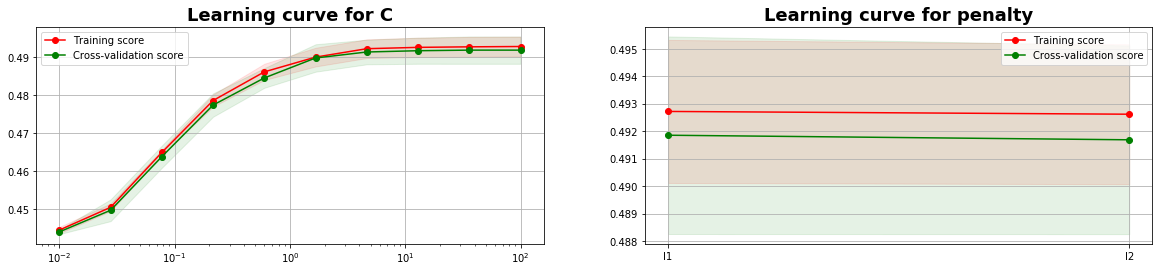

In [95]:
plot_learning_curve(grid.best_params_, grid.cv_results_, params_logscale=['C'])

In [99]:
# Compute coefficients on each split with best params
estimator = clone(grid.best_estimator_)
splits = strat_cv.split(X_ttrain, y_train)
list_coeffs = []

for j, (idx_train, idx_test) in enumerate(splits):
    estimator.fit(X_ttrain.iloc[idx_train], y_train.iloc[idx_train])
    coeffs = pd.DataFrame({'Coef': estimator.coef_.flatten()}, index=X_ttrain.columns)
    list_coeffs.append(coeffs)

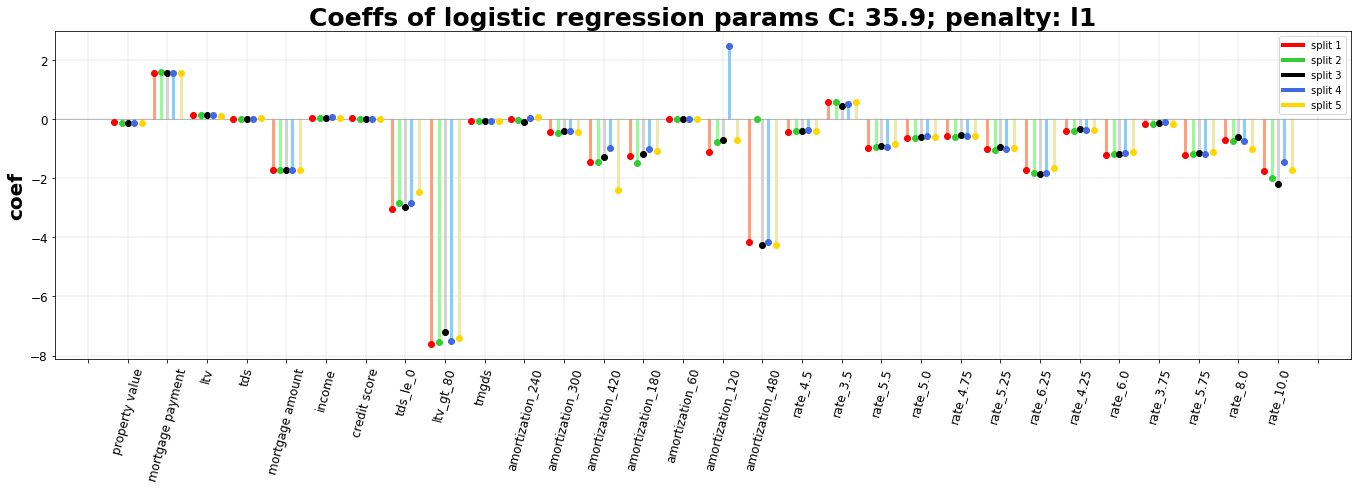

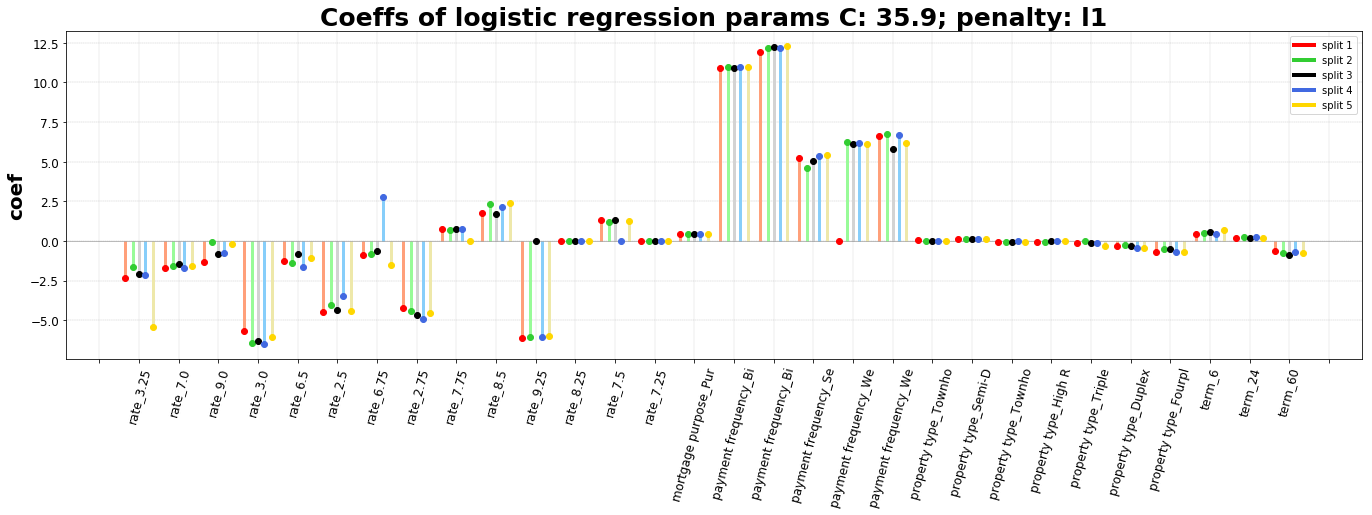

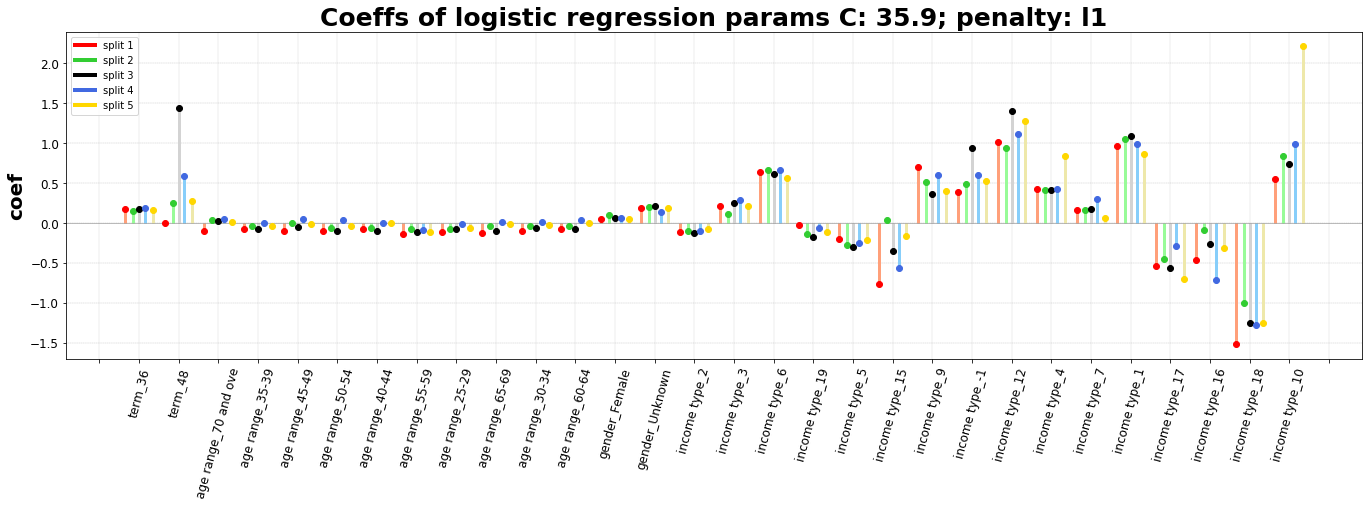

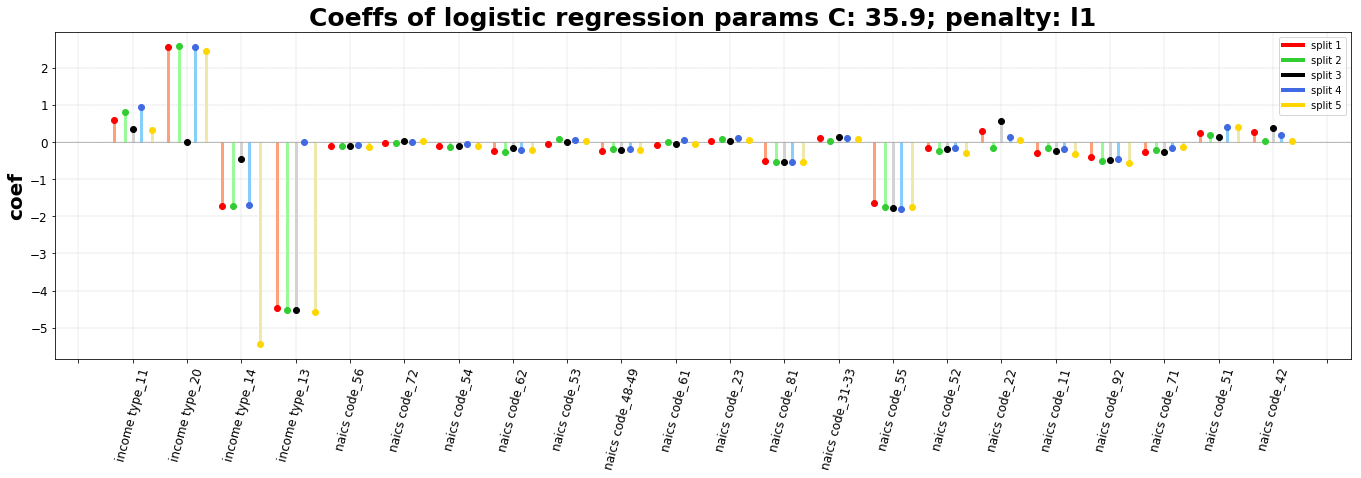

In [100]:
# Plot coefficients 
str_params = []
for k, v in grid.best_params_.items():
    if type(v)==np.int64:
        str_params.append("%s: %d" % (str(k), v))
    elif type(v)==np.float64:
        str_params.append("%s: %.3g" % (str(k), v))
    else:
        str_params.append("%s: %s" % (str(k), str(v)))

title = "logistic regression params %s" % ('; '.join(str_params))

n_coeffs = list_coeffs[0].shape[0]
n_coeffs_fig = 30
n_fig = np.int(np.ceil(n_coeffs/n_coeffs_fig))
for j in range(n_fig):
    sublist_coeffs = [coeffs.iloc[n_coeffs_fig*j:n_coeffs_fig*(j+1)] for coeffs in list_coeffs]
    plot_compare_coeffs(sublist_coeffs, title)

In [101]:
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

X_test['Result_Predicted'] = grid.best_estimator_.predict(X_ttest)
X_test['Unique_ID'] = X_test['unique_id']
X_test.loc[:, 'Result_Predicted']  = X_test['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(X_test[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "sub_%s_gross.csv" % model_name), index=False)

del X_test['Unique_ID']
del X_test['Result_Predicted']

# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, '%s_gross.pkl' % model_name))

['../trained_models/linear/logreg_gross.pkl']

## II.2 RandomForest

In [102]:
%%time
model_type = 'ensemble'
model_name = 'randomforest'
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)
    
clf = RandomForestClassifier(criterion='gini',
                             min_samples_leaf=1,
                             max_features='sqrt',
                             max_leaf_nodes=None,
                             bootstrap=True,
                             random_state=random_state,
                             class_weight="balanced")

param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60], 
              'max_depth': [5, 6, 7, 8, 9, 10, 12, 15]}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=strat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)

warnings.filterwarnings('ignore')
grid = grid.fit(X_ttrain, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   13.4s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:  2.1min finished


CPU times: user 2.81 s, sys: 199 ms, total: 3.01 s
Wall time: 2min 5s


In [103]:
y_pred = grid.best_estimator_.predict(X_ttrain)
recalls, precisions, f1s = f1_macro(y_pred, y_train)
print("="*40)
print("Best params %s" % grid.best_params_)
for k in recalls.keys():
    print("Class %d | precision %.4g; recall %.4g; f1 %.4g " % (k, recalls[k], precisions[k], f1s[k]))
print("="*40)

Best params {'max_depth': 15, 'n_estimators': 40}
Class 1 | precision 0.9134; recall 0.7476; f1 0.8222 
Class 0 | precision 0.4373; recall 0.7344; f1 0.5481 


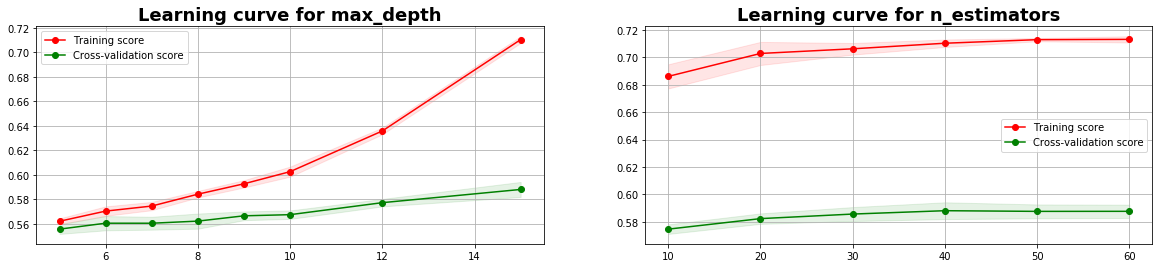

In [104]:
plot_learning_curve(grid.best_params_, grid.cv_results_, params_logscale=['C'])

### Make prediction and dump the model

In [1073]:
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

X_test['Result_Predicted'] = grid.best_estimator_.predict(X_ttest)
X_test['Unique_ID'] = X_test['unique_id']
X_test.loc[:, 'Result_Predicted']  = X_test['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(X_test[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "sub_%s_gross.csv" % model_name), index=False)

del X_test['Unique_ID']
del X_test['Result_Predicted']

# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, '%s_gross.pkl' % model_name))

## II.3 XGBoost

In [118]:
%%time
model_type = 'ensemble'
model_name = 'xgboost'
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)

X_tttrain, X_tttval, y_ttrain, y_ttval = train_test_split(X_ttrain, y_train, stratify=y_train, test_size=0.2, 
                                                          random_state=random_state) 

dtrain = xgb.DMatrix(X_tttrain, label=y_ttrain)
dvalid = xgb.DMatrix(X_tttval, label=y_ttval)
dtest = xgb.DMatrix(X_ttest)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.4, 'colsample_bytree': 1.0, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 3., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'aucpr', 'objective': 'binary:logistic'}


clf_xgb = xgb.train(xgb_pars, dtrain, 80, watchlist, early_stopping_rounds=50, maximize=True, verbose_eval=10)

[0]	train-aucpr:0.880715	valid-aucpr:0.874591
Multiple eval metrics have been passed: 'valid-aucpr' will be used for early stopping.

Will train until valid-aucpr hasn't improved in 50 rounds.
[10]	train-aucpr:0.907673	valid-aucpr:0.888557
[20]	train-aucpr:0.918117	valid-aucpr:0.890001
[30]	train-aucpr:0.925937	valid-aucpr:0.889955
[40]	train-aucpr:0.933099	valid-aucpr:0.886677
[50]	train-aucpr:0.939082	valid-aucpr:0.88512
[60]	train-aucpr:0.944297	valid-aucpr:0.885612
Stopping. Best iteration:
[19]	train-aucpr:0.917132	valid-aucpr:0.890584

CPU times: user 31.3 s, sys: 413 ms, total: 31.7 s
Wall time: 31.7 s


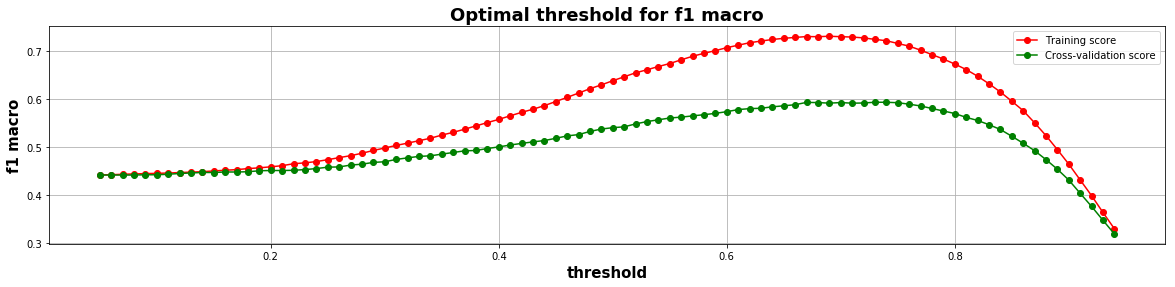

CPU times: user 753 ms, sys: 14.6 ms, total: 768 ms
Wall time: 772 ms


In [137]:
%%time
# See which threshold yields the best f1_macro on validation set
y_prob_train = clf_xgb.predict(dtrain)
y_prob_val = clf_xgb.predict(dvalid)

thresh = np.r_[0.05:0.95:0.01]
f1_macro_train = []
f1_macro_val = []
best_th = 0
best_f1_val = 0

for th in thresh:
    f1_train = f1_score(y_ttrain, np.where(y_prob_train > th, 1, 0), average='macro')
    f1_val = f1_score(y_ttval, np.where(y_prob_val > th, 1, 0), average='macro')
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_th = th
    f1_macro_train.append(f1_train)
    f1_macro_val.append(f1_val)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
ax.grid()
ax.plot(thresh, f1_macro_train, 'o-', color="r", label="Training score")
ax.plot(thresh, f1_macro_val, 'o-', color="g", label="Cross-validation score")
ax.set_xlabel("threshold", fontsize=15, fontweight='bold')
ax.set_ylabel("f1 macro", fontsize=15, fontweight='bold')
ax.set_title('Optimal threshold for f1 macro', fontsize=18, fontweight='bold')
ax.legend(loc="best")
plt.show(fig)

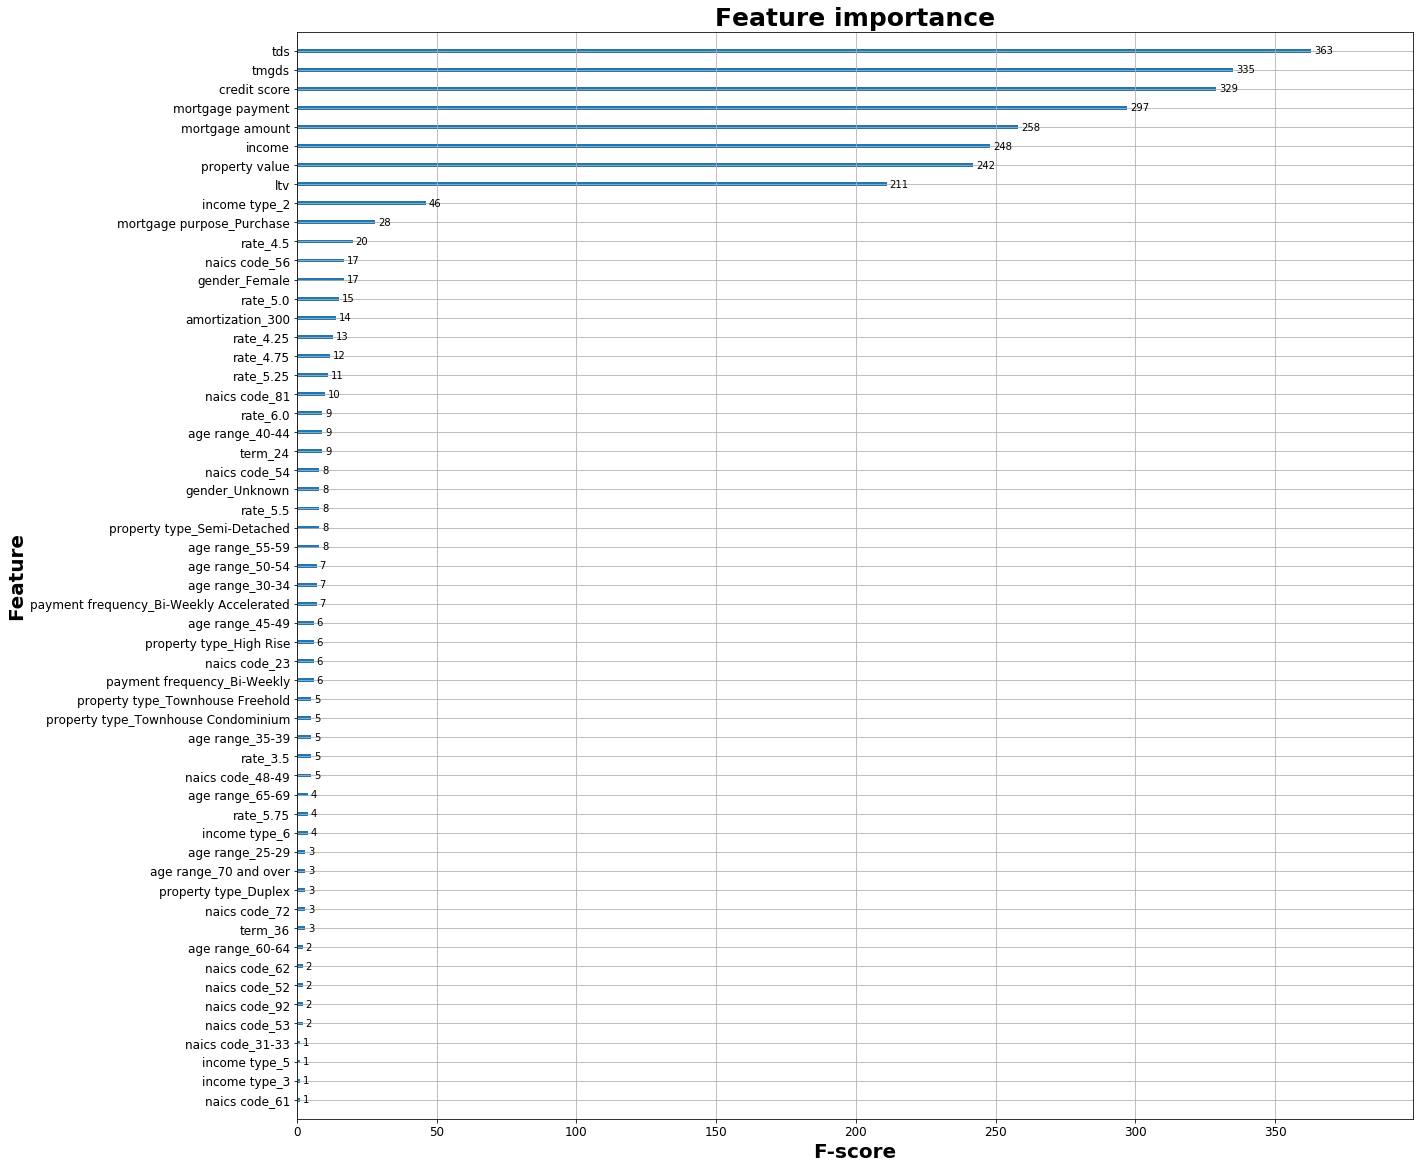

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
plot_importance(clf_xgb, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylabel("Feature", fontweight='bold', fontsize=20)
ax.set_xlabel("F-score", fontweight='bold', fontsize=20)
ax.set_title("Feature importance", fontweight="bold", fontsize=25)
plt.show(fig)

### Make prediction and dump the model

In [140]:
submission_file = pd.read_csv("../data/CAX_MortgageModeling_SubmissionFormat.csv")

X_test['Result_Predicted'] =  np.where(clf_xgb.predict(dtest) > best_th, 1, 0)
X_test['Unique_ID'] = X_test['unique_id']
X_test.loc[:, 'Result_Predicted']  = X_test['Result_Predicted'].map({0: "NOT FUNDED", 1:"FUNDED"})

submission_file = submission_file[['Unique_ID']].merge(X_test[['Unique_ID', 'Result_Predicted']], 
                                                       how='left', on=['Unique_ID'])
submission_file.to_csv(os.path.join(path_sub, "sub_%s_gross.csv" % model_name), index=False)

del X_test['Unique_ID']
del X_test['Result_Predicted']

# Save the result of the gridsearch
joblib.dump(grid, os.path.join(path_model, '%s_gross.pkl' % model_name))

['../trained_models/ensemble/xgboost_gross.pkl']

## IV. Support Vector Machines

In [18]:
from sklearn.datasets import dump_svmlight_file

In [23]:
dump_svmlight_file(X=X_ttrain.iloc[:1000], y=y_train.iloc[:1000], f="../../sofia-ml-mod/sofia-ml/mortgage/mortgage.train")

In [20]:
os.getcwd()

'/Users/pradaty/Documents/crowd_analytix/mortgage/notebook'

In [16]:
%%time
clf = LinearSVC(penalty='l2', C=0.1, dual=False, loss='squared_hinge', random_state=random_state, verbose=3, max_iter=10000)
clf.fit(X_ttrain, y_train)

[LibLinear]CPU times: user 668 ms, sys: 19.4 ms, total: 688 ms
Wall time: 691 ms


In [17]:
np.bincount(clf.predict(X_ttrain))

array([  561, 45081])

In [170]:
%%time
model_type = 'svm'
model_name = 'svc'
path_sub = "../submissions/%s" % model_type
path_model = "../trained_models/%s" % model_type
if not os.path.exists(path_sub):
    os.mkdir(path_sub)
if not os.path.exists(path_model):
    os.mkdir(path_model)
    
clf = SVC(kernel='linear', degree=3, decision_function_shape='ovr', random_state=random_state)
param_grid = {'C': np.logspace(-3, 3, 10)}
grid = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1_macro', 
                    cv=strat_cv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=3)
warnings.filterwarnings('ignore')
grid = grid.fit(X_ttrain, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 